# Assessment of Renewable Energy Potentials based on Land Availability

The analysis of land availability for renewable energy potentials is divided into three stages. In this script, we will focus on the second stage: **Renewable energy potentials**

-Goal: apply energy parameters onto the available land (output from the first stage).

-Steps:

1. Import data
2. Data unification
3. Setup 3 maps for 3 scenarios
4. Energy parameters (solar and wind)

In [1]:
# import necessary library
%matplotlib inline
import matplotlib.pyplot as plt # graph plotting package
from matplotlib.patches import Patch # for legend editing
from matplotlib.colors import BoundaryNorm
from matplotlib import rcParams, cycler
import os # operating system interfaces 
import numpy as np # array and data sorting package
import pandas as pd # dataframe sorting package
import geopandas as gpd # geospatial data processing package
from geopandas import datasets, GeoDataFrame, read_file # geospatial data processing package
from geopandas.tools import overlay # for overlay function
import shapely.speedups # geospatial data speedup package
from shapely import wkt # provide dumpers and loaders inspired by Python’s pickle module
from shapely.geometry import Point # processing for data in point form
import rasterio # geospatial data (raster file) processing package
from rasterio.merge import merge
from rasterio.plot import show # plot the raster data
from rasterio.plot import show_hist
from rasterstats import zonal_stats
import contextily # the package for fetching basemaps
import glob # finds all the pathnames matching a specified pattern
import pyproj # self-defined coordination reference system
from pyproj import CRS # self-defined coordination reference system
from pyproj import Geod # performs forward and inverse geodetic, or Great Circle, computations
from osgeo import gdal, gdal_array

shapely.speedups.enable() # spped up the calculation of mapping in shapely library
name = 'Vietnam'

## 1. Import data

a. Import the **basemap** which is from the **result of stage 1**

b. Import the **map layers** of **open digital elevation model (DEM)** for elevation calculations

c. Import **wind resources** for wind potentials visualization
 
d. Import **solar resources**  for solar potentials visualization

In [2]:
%%time
basemap = 'Vietnam/00_data_vector/01_admin_level2/vnm_admbnda_adm2_gov_20201027.shp'
map_gdf = gpd.read_file(basemap)

al_gdf = gpd.read_file('Vietnam/01_output_stage1/01_vn_available_land.shp') # # 2. Import available land from stgae 1
ts_gdf = gpd.read_file('Vietnam/00_data_vector/09_transmission_lines/TransmissionLine_KV.shp') # 3. import shapefiles of transmission lines

dem_ras = 'Vietnam/00_data_raster/01_digital_elevaton_model_vn/dem_compress.tif' # open digital elevation model file (Geotiff, raster file)
#rd_dem = rd.LoadGDAL(dem_ras) # Load the DEM with richdem

#Fill depressions in the DEM to avoid making an unnecessary copy. This saves both time and RAM. 
#rd.FillDepressions(rd_dem, epsilon=False, in_place=True)

Wall time: 798 ms


In [3]:
wind_files = os.listdir("Vietnam/00_data_raster/03_wind_sources/")
wind_files = sorted(wind_files)   
wt_cf_files = list(filter(lambda f: f.startswith('VNM_capacity-factor'), wind_files)) # to list files of capacity factor
wt_pd_files = list(filter(lambda f: f.startswith('VNM_power-density'), wind_files)) # to list files of power density
wt_pd_files = list(filter(lambda f: f.endswith('.tif'), wt_pd_files)) # remove geojson files
wt_spd_files = list(filter(lambda f: f.startswith('VNM_wind-speed'), wind_files)) # to list files of wind speed
wt_spd_files = list(filter(lambda f: f.endswith('.tif'), wt_spd_files)) # remove geojson files
print(wt_cf_files, wt_pd_files, wt_spd_files)

['VNM_capacity-factor_IEC1.tif', 'VNM_capacity-factor_IEC2.tif', 'VNM_capacity-factor_IEC3.tif'] ['VNM_power-density_100m.tif', 'VNM_power-density_10m.tif', 'VNM_power-density_150m.tif', 'VNM_power-density_200m.tif', 'VNM_power-density_50m.tif'] ['VNM_wind-speed_100m.tif', 'VNM_wind-speed_10m.tif', 'VNM_wind-speed_150m.tif', 'VNM_wind-speed_200m.tif', 'VNM_wind-speed_50m.tif']


In [4]:
pv_files = os.listdir("Vietnam/00_data_raster/02_solar_sources/Vietnam_GISdata_LTAy_YearlyMonthlyTotals_GlobalSolarAtlas-v2_GEOTIFF/")
pv_files = sorted(pv_files)
pv_files = list(filter(lambda f: f.endswith('.tif'), pv_files)) # to list files of power density
print(pv_files)

['DIF.tif', 'DNI.tif', 'GHI.tif', 'GTI.tif', 'OPTA.tif', 'PVOUT.tif', 'TEMP.tif']


## 2. Data Unification

### a. Sort and re-index the **basemap** (**administrative level**)

In [5]:
new_map_gdf = map_gdf.copy()
new_map_gdf = new_map_gdf[['ADM0_EN', 'ADM1_EN','ADM2_EN', 'geometry']] # only select necessary columns
new_map_gdf.rename(columns={'ADM0_EN': 'country_name','ADM1_EN': 'ad_lv_1','ADM2_EN': 'ad_lv_2','geometry': 'geometry'}, inplace = True)
print(new_map_gdf.columns)

Index(['country_name', 'ad_lv_1', 'ad_lv_2', 'geometry'], dtype='object')


## 3. Setup maps for 3 Scenarios

[EPSG:4326/WGS 84](https://epsg.io/4326) - World Geodetic System 1984, used in GPS (common longtitude/latitude system) <br>
[EPSG:3405/VN-2000 / UTM zone 48N](https://epsg.io/3405) - Accurate projection and caluclation of areas (units in meters) <br>
*UTM: Universal Transverse Mercator coordinate system

### a. al (available land) (from stgae 1)

In [6]:
# crs for system unit in meter, from https://epsg.io/
crs_m = CRS.from_proj4("+proj=utm +zone=48 +ellps=WGS84 +towgs84=-192.873,-39.382,-111.202,-0.00205,-0.0005,0.00335,0.0188 +units=m +no_defs ")

# Original CRS: EPSG:4326 (Unit: longtitude, latitiude)
al_m_gdf = al_gdf.to_crs(crs_m) # Reprojection to crs
al_km_df = al_m_gdf.area/ 10**6 # Areas in square kilometers

al_save_gdf = al_gdf.drop(columns=['geometry']) # remove column 'geometry' and add column 'area'
al_save_gdf['area_km2'] = al_km_df
al_save_gdf.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario1_al.csv', index = True) # save csv file

print('Total area of', name, ':', al_km_df.sum(axis = 0, skipna = True),'km^2')

Total area of Vietnam : 97818.83178687205 km^2


### b. al+ts (available land excludes areas whose distances are larger than 10km from existing transmission lines)

In [7]:
new_ts_gdf = ts_gdf.copy()
new_ts_gdf = new_ts_gdf.drop(columns=['Id']) # remove Id column
new_ts_gdf['geometry'] = new_ts_gdf.geometry.buffer(0.01, cap_style = 3, join_style = 1) # increase the buffer of road strings (longitude crs. unit in (10 km))

%time al_ts_merge_gdf = gpd.overlay(al_gdf, new_ts_gdf,  how = 'intersection') # Intersection: only the areas include al+es and ts maps
al_ts_merge_gdf.to_file(r'Vietnam/02_output_stage2/02_vn_scenario2_al_ts.shp') # Save the shapefile

<ipython-input-7-0913f29dde94>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_ts_gdf['geometry'] = new_ts_gdf.geometry.buffer(0.01, cap_style = 3, join_style = 1) # increase the buffer of road strings (longitude crs. unit in (10 km))


Wall time: 2.03 s


In [8]:
# Original CRS: EPSG:4326 (Unit: longtitude, latitiude)
al_ts_m_gdf = al_ts_merge_gdf.to_crs(crs_m) # Reprojection to crs
al_ts_km_df = al_ts_m_gdf.area/ 10**6 # Areas in square kilometers

al_ts_csv_gdf = al_ts_m_gdf.drop(columns=['geometry']) # remove column 'geometry' and add column 'area'
al_ts_csv_gdf['area_km2'] = al_ts_km_df
al_ts_csv_gdf.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario2_al_ts.csv', index = True) # save csv file

print('Total area of scenario 2 in', name, ':', al_ts_km_df.sum(axis = 0, skipna = True),'km^2')

Total area of scenario 2 in Vietnam : 7616.3159310293995 km^2


### c. al+ts+sl (former two exclude the area whose slope rate is larger than 30%)

In [9]:
zs_df = pd.DataFrame(zonal_stats(al_ts_merge_gdf, dem_ras, stats=['mean'])) # make a dataframe including the a list of dictionary objects that holds the calculated statistics for each feature/polygon in the same order.
zs_df.rename(columns={'mean':'slope_degrees'}, inplace=True)
concat_gdf = pd.concat([al_ts_merge_gdf, zs_df], axis=1)
concat_gdf.dropna(axis='rows')

al_ts_sl_gdf = concat_gdf[~(concat_gdf['slope_degrees'] > 30)] # exclude the slope that is over 30%
al_ts_sl_drop_gdf = al_ts_sl_gdf.dropna()

al_ts_sl_drop_gdf.to_file(r'Vietnam/02_output_stage2/02_vn_scenario3_al_ts_sl.shp') # Save the shapefile

# Get the total land areas
# Original CRS: EPSG:4326 (Unit: longtitude, latitiude)
# Reprojection to crs
al_ts_sl_m_gdf = al_ts_sl_drop_gdf.to_crs(crs_m) # Reprojection to crs
# Areas in square kilometers
al_ts_sl_km_df = al_ts_sl_m_gdf.area/ 10**6 # Areas in square kilometers

al_ts_sl_csv_gdf = al_ts_sl_m_gdf.drop(columns=['geometry']) # remove column 'geometry' and add column 'area'
al_ts_sl_csv_gdf['area_km2'] = al_ts_sl_km_df
al_ts_sl_csv_gdf.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario3_al_ts_sl.csv', index = True) # Save csv file

print('Total area of scenario 3 in', name, ':', al_ts_sl_km_df.sum(axis = 0, skipna = True),'km^2')

<ipython-input-9-592979517fd6>:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  al_ts_sl_drop_gdf.to_file(r'Vietnam/02_output_stage2/02_vn_scenario3_al_ts_sl.shp') # Save the shapefile


Total area of scenario 3 in Vietnam : 1609.2473186850455 km^2


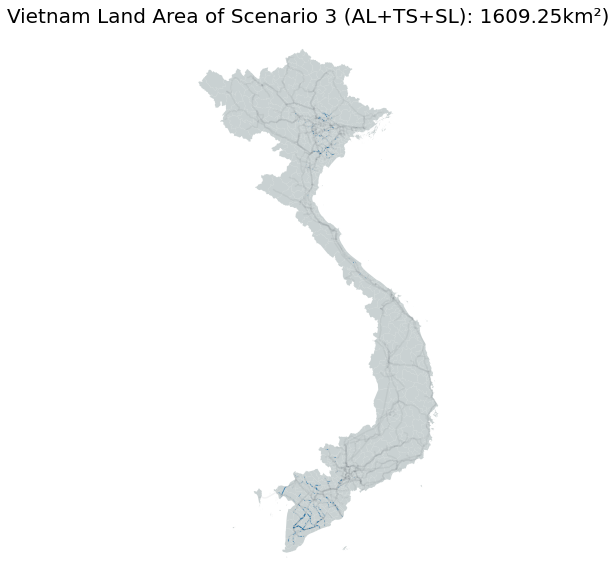

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Use VN_landuse boundary to define all sizes of the maps
ax.set_xlim(101, 110)
ax.set_ylim(8, 24)

map_gdf.plot(ax=ax, markersize=10, alpha=0.5, categorical=True, legend=True, color='#95A5A6') # add basemap to the plot (grey)

ts_gdf.plot(ax=ax, markersize=10, alpha=0.05, categorical=True, legend=True, color='#17202A') # add the transmission layer to the plot (black)

al_ts_sl_drop_gdf.plot(ax=ax, categorical=True, legend=True) # add available land area of scenario 3

# Set title
ax.set_title("Vietnam Land Area of Scenario 3 (AL+TS+SL): {0:.{1}f}km\u00b2)".format(al_ts_sl_km_df.sum(axis = 0, skipna = True), 2), fontsize=20)
ax.set_axis_off()

plt.savefig(r'Vietnam/02_output_stage2/02_vn_al_ts_sl.tiff', dpi=500)
plt.show()

## 4. Energy parameters (solar and wind)

### a. Wind Calculation

In [16]:
wt_path = 'Vietnam/00_data_raster/03_wind_sources/'
wt_ice_ras = ['wt_cf_iec1_ras', 'wt_cf_iec2_ras', 'wt_cf_iec3_ras']
wt_pd_ras = ['wt_pd_100_ras', 'wt_pd_10_ras', 'wt_pd_150_ras', 'wt_pd_200_ras', 'wt_pd_50_ras']
wt_spd_ras = ['wt_spd_100_ras', 'wt_spd_10_ras', 'wt_spd_150_ras', 'wt_spd_200_ras', 'wt_spd_50_ras']
cf_unit = ['capacity_factor_iec1','capacity_factor_iec2','capacity_factor_iec3']
pd_unit = ['power_density_height100m_w/s', 'power_density_height10m_w/s', 'power_density_height150m_w/s', 'power_density_height200m_w/s', 'power_density_height50m_w/s']
spd_unit = ['ws_h100m_m/s', 'ws_h10m_m/s', 'ws_h150m_m/s', 'ws_h200m_m/s', 'ws_h50m_m/s']

In [17]:
%%time
# a. scenario 1 al (available land)
wt_sc1_dict = {} # empty dictionary
concat_sc1_dict = {} # empty dictionary
for i in range(len(wt_ice_ras)):
    zs = zonal_stats(al_gdf, wt_path + wt_cf_files[i], stats=['mean']) # calculate average cf values of each zones 
    wt_sc1_dict[wt_ice_ras[i]] = pd.DataFrame(zs)
    wt_sc1_dict[wt_ice_ras[i]].rename(columns={'mean': cf_unit[i]}, inplace=True)

for i in range(len(wt_pd_ras)):
    zs = zonal_stats(al_gdf, wt_path + wt_pd_files[i], stats=['mean']) # calculate average power density values of each zones 
    wt_sc1_dict[wt_pd_ras[i]] = pd.DataFrame(zs)
    wt_sc1_dict[wt_pd_ras[i]].rename(columns={'mean': pd_unit[i]}, inplace=True)

for i in range(len(wt_spd_ras)):
    zs = zonal_stats(al_gdf, wt_path + wt_spd_files[i], stats=['mean']) # calculate average wind speed values of each zones 
    wt_sc1_dict[wt_spd_ras[i]] = pd.DataFrame(zs)
    wt_sc1_dict[wt_spd_ras[i]].rename(columns={'mean': spd_unit[i]}, inplace=True)

Wall time: 1min 19s


In [18]:
concat_sc1_dict['w1_sc1_gdf'] = pd.concat([al_gdf, wt_sc1_dict['wt_cf_iec1_ras']], axis=1)
for i in range(1, len(wt_ice_ras)): 
    concat_sc1_dict['w{0}_sc1_gdf'.format(i+1)] = pd.concat([concat_sc1_dict['w{0}_sc1_gdf'.format(i)], wt_sc1_dict[wt_ice_ras[i]]], axis=1)
for i in range(len(wt_pd_ras)): 
    concat_sc1_dict['w{0}_sc1_gdf'.format(len(wt_ice_ras)+i+1)] = pd.concat([concat_sc1_dict['w{0}_sc1_gdf'.format(len(wt_ice_ras)+i)], wt_sc1_dict[wt_pd_ras[i]]], axis=1)
for i in range(len(wt_spd_ras)): 
    concat_sc1_dict['w{0}_sc1_gdf'.format(len(wt_ice_ras)+len(wt_pd_ras)+i+1)] = pd.concat([concat_sc1_dict['w{0}_sc1_gdf'.format(len(wt_ice_ras)+len(wt_pd_ras)+i)], wt_sc1_dict[wt_spd_ras[i]]], axis=1)

# remove column 'geometry' -> become dataframe to save the document
wt_sc1_save_df = concat_sc1_dict['w13_sc1_gdf'].dropna()
wt_sc1_save_df = wt_sc1_save_df.drop(columns=['geometry'])
wt_sc1_save_df.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario1_wind.csv', index = True)

In [19]:
%%time
# b. al+ts (available land + max. 10km from transimission lines)
wt_sc2_dict = {} # empty dictionary
concat_sc2_dict = {} # empty dictionary
for i in range(len(wt_ice_ras)):
    zs = zonal_stats(al_ts_merge_gdf, wt_path + wt_cf_files[i], stats=['mean']) # calculate average cf values of each zones 
    wt_sc2_dict[wt_ice_ras[i]] = pd.DataFrame(zs)
    wt_sc2_dict[wt_ice_ras[i]].rename(columns={'mean': cf_unit[i]}, inplace=True)

for i in range(len(wt_pd_ras)):
    zs = zonal_stats(al_ts_merge_gdf, wt_path + wt_pd_files[i], stats=['mean']) # calculate average power density values of each zones 
    wt_sc2_dict[wt_pd_ras[i]] = pd.DataFrame(zs)
    wt_sc2_dict[wt_pd_ras[i]].rename(columns={'mean': pd_unit[i]}, inplace=True)

for i in range(len(wt_spd_ras)):
    zs = zonal_stats(al_ts_merge_gdf, wt_path + wt_spd_files[i], stats=['mean']) # calculate average wind speed values of each zones 
    wt_sc2_dict[wt_spd_ras[i]] = pd.DataFrame(zs)
    wt_sc2_dict[wt_spd_ras[i]].rename(columns={'mean': spd_unit[i]}, inplace=True)

Wall time: 1min 34s


In [20]:
concat_sc2_dict['w1_sc2_gdf'] = pd.concat([al_ts_merge_gdf, wt_sc2_dict['wt_cf_iec1_ras']], axis=1)
for i in range(1, len(wt_ice_ras)): 
    concat_sc2_dict['w{0}_sc2_gdf'.format(i+1)] = pd.concat([concat_sc2_dict['w{0}_sc2_gdf'.format(i)], wt_sc2_dict[wt_ice_ras[i]]], axis=1)
for i in range(len(wt_pd_ras)): 
    concat_sc2_dict['w{0}_sc2_gdf'.format(len(wt_ice_ras)+i+1)] = pd.concat([concat_sc2_dict['w{0}_sc2_gdf'.format(len(wt_ice_ras)+i)], wt_sc2_dict[wt_pd_ras[i]]], axis=1)
for i in range(len(wt_spd_ras)): 
    concat_sc2_dict['w{0}_sc2_gdf'.format(len(wt_ice_ras)+len(wt_pd_ras)+i+1)] = pd.concat([concat_sc2_dict['w{0}_sc2_gdf'.format(len(wt_ice_ras)+len(wt_pd_ras)+i)], wt_sc2_dict[wt_spd_ras[i]]], axis=1)


# remove column 'geometry' -> become dataframe to save the document
wt_sc2_save_df = concat_sc2_dict['w13_sc2_gdf'].dropna()
wt_sc2_save_df = wt_sc2_save_df.drop(columns=['geometry'])
wt_sc2_save_df.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario2_wind.csv', index = True)

In [21]:
%%time
# c. al+ts+sl (from b excluding slop rate larger than 30%)
wt_sc3_dict = {} # empty dictionary
concat_sc3_dict = {} # empty dictionary
for i in range(len(wt_ice_ras)):
    zs = zonal_stats(al_ts_sl_gdf, wt_path + wt_cf_files[i], stats=['mean']) # calculate average cf values of each zones 
    wt_sc3_dict[wt_ice_ras[i]] = pd.DataFrame(zs)
    wt_sc3_dict[wt_ice_ras[i]].rename(columns={'mean': cf_unit[i]}, inplace=True)

for i in range(len(wt_pd_ras)):
    zs = zonal_stats(al_ts_sl_gdf, wt_path + wt_pd_files[i], stats=['mean']) # calculate average power density values of each zones 
    wt_sc3_dict[wt_pd_ras[i]] = pd.DataFrame(zs)
    wt_sc3_dict[wt_pd_ras[i]].rename(columns={'mean': pd_unit[i]}, inplace=True)

for i in range(len(wt_spd_ras)):
    zs = zonal_stats(al_ts_sl_gdf, wt_path + wt_spd_files[i], stats=['mean']) # calculate average wind speed values of each zones 
    wt_sc3_dict[wt_spd_ras[i]] = pd.DataFrame(zs)
    wt_sc3_dict[wt_spd_ras[i]].rename(columns={'mean': spd_unit[i]}, inplace=True)

Wall time: 37.1 s


In [22]:
concat_sc3_dict['w1_sc3_gdf'] = pd.concat([al_ts_sl_gdf, wt_sc3_dict['wt_cf_iec1_ras']], axis=1)
for i in range(1, len(wt_ice_ras)): 
    concat_sc3_dict['w{0}_sc3_gdf'.format(i+1)] = pd.concat([concat_sc3_dict['w{0}_sc3_gdf'.format(i)], wt_sc3_dict[wt_ice_ras[i]]], axis=1)
for i in range(len(wt_pd_ras)): 
    concat_sc3_dict['w{0}_sc3_gdf'.format(len(wt_ice_ras)+i+1)] = pd.concat([concat_sc3_dict['w{0}_sc3_gdf'.format(len(wt_ice_ras)+i)], wt_sc3_dict[wt_pd_ras[i]]], axis=1)
for i in range(len(wt_spd_ras)): 
    concat_sc3_dict['w{0}_sc3_gdf'.format(len(wt_ice_ras)+len(wt_pd_ras)+i+1)] = pd.concat([concat_sc3_dict['w{0}_sc3_gdf'.format(len(wt_ice_ras)+len(wt_pd_ras)+i)], wt_sc3_dict[wt_spd_ras[i]]], axis=1)


# remove column 'geometry' -> become dataframe to save the document
wt_sc3_save_df = concat_sc3_dict['w13_sc3_gdf'].dropna()
wt_sc3_save_df = wt_sc3_save_df.drop(columns=['geometry'])
wt_sc3_save_df.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario3_wind.csv', index = True)

###  Wind Visualizations (take one example)

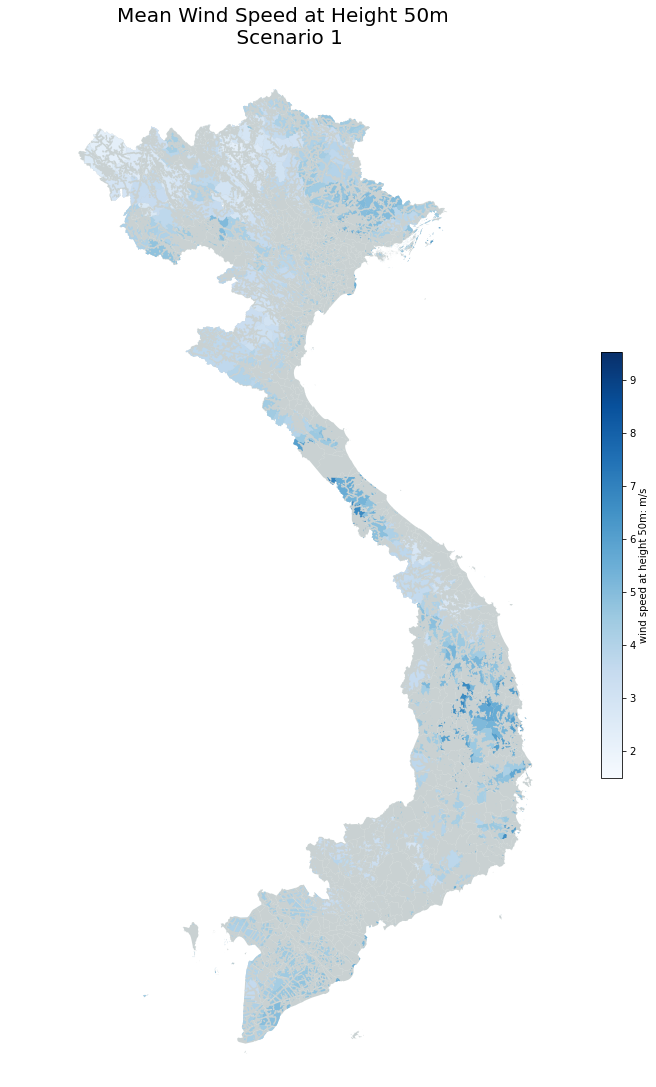

In [23]:
fig, ax = plt.subplots(figsize=(10, 20))

# Use VN_landuse boundary to define all sizes of the maps
ax.set_xlim(101, 110)
ax.set_ylim(8, 24)

# add basemap to the plot (grey)
new_map_gdf.plot(ax=ax, markersize=10, alpha=0.5, categorical=True, legend=True, color='#95A5A6')

# add basemap to the plot (grey)
#land_area_new_df.plot(ax=ax, markersize=10, alpha=0.5, categorical=True, legend=True, color='#95A5A6')
concat_sc1_dict['w13_sc1_gdf'].plot(column='ws_h50m_m/s', ax=ax, cmap='Blues', legend=True, legend_kwds={'shrink': 0.3, 'label': 'wind speed at height 50m: m/s'})

# Set titles
ax.set_title('Mean Wind Speed at Height 50m \n Scenario 1', fontsize=20)
ax.set_axis_off()


plt.savefig(r'Vietnam/02_output_stage2/02_vn_scenario1_wind_speed_h50m.tiff', dpi=500)
plt.tight_layout()

### b. Solar Calculation

In [43]:
pv_path = 'Vietnam/00_data_raster/02_solar_sources/Vietnam_GISdata_LTAy_YearlyMonthlyTotals_GlobalSolarAtlas-v2_GEOTIFF/'
pv_ras = ['dif_ras', 'dni_ras', 'ghi_ras', 'gti_ras', 'opta_ras', 'pvout_ras', 'temp_ras']
pv_unit = ['dif_kWh/m2a','dni_kWh/m2a','ghi_kWh/m2a','gti_kWh/m2a','opta_tilt_degree','pvout_kWh/kWp','temp_celcius']

In [44]:
%%time
# a. scenario 1 al (available land)
pv_sc1_dict = {} # empty dictionary
concat_sc1_dict = {} # empty dictionary
for i in range(len(pv_ras)):
    zs = zonal_stats(al_gdf, pv_path + pv_files[i], stats=['mean']) # calculate average cf values of each zones 
    pv_sc1_dict[pv_ras[i]] = pd.DataFrame(zs)
    pv_sc1_dict[pv_ras[i]].rename(columns={'mean': pv_unit[i]}, inplace=True)

concat_sc1_dict['p1_sc1_gdf'] = pd.concat([al_gdf, pv_sc1_dict['dif_ras']], axis=1)
for i in range(1, len(pv_ras)): 
    concat_sc1_dict['p{0}_sc1_gdf'.format(i+1)] = pd.concat([concat_sc1_dict['p{0}_sc1_gdf'.format(i)], pv_sc1_dict[pv_ras[i]]], axis=1)

# remove column 'geometry' -> become dataframe to save the document
pv_sc1_save_df = concat_sc1_dict['p7_sc1_gdf'].dropna()
pv_sc1_save_df = pv_sc1_save_df.drop(columns=['geometry'])
pv_sc1_save_df.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario1_solar.csv', index = True)

Wall time: 39.7 s


In [45]:
%%time
# b. al+ts (available land + max. 10km from transimission lines)
pv_sc2_dict = {} # empty dictionary
concat_sc2_dict = {} # empty dictionary
for i in range(len(pv_ras)):
    zs = zonal_stats(al_ts_merge_gdf, pv_path + pv_files[i], stats=['mean']) # calculate average cf values of each zones 
    pv_sc2_dict[pv_ras[i]] = pd.DataFrame(zs)
    pv_sc2_dict[pv_ras[i]].rename(columns={'mean': pv_unit[i]}, inplace=True)

concat_sc2_dict['p1_sc2_gdf'] = pd.concat([al_ts_merge_gdf, pv_sc2_dict['dif_ras']], axis=1)
for i in range(1, len(pv_ras)): 
    concat_sc2_dict['p{0}_sc2_gdf'.format(i+1)] = pd.concat([concat_sc2_dict['p{0}_sc2_gdf'.format(i)], pv_sc2_dict[pv_ras[i]]], axis=1)

# remove column 'geometry' -> become dataframe to save the document
pv_sc2_save_df = concat_sc2_dict['p7_sc2_gdf'].dropna()
pv_sc2_save_df = pv_sc2_save_df.drop(columns=['geometry'])
pv_sc2_save_df.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario2_solar.csv', index = True)

Wall time: 37.9 s


In [46]:
%%time
# c. al+ts+sl (from b excluding slop rate larger than 30%)
pv_sc3_dict = {} # empty dictionary
concat_sc3_dict = {} # empty dictionary
for i in range(len(pv_ras)):
    zs = zonal_stats(al_ts_sl_gdf, pv_path + pv_files[i], stats=['mean']) # calculate average cf values of each zones 
    pv_sc3_dict[pv_ras[i]] = pd.DataFrame(zs)
    pv_sc3_dict[pv_ras[i]].rename(columns={'mean': pv_unit[i]}, inplace=True)

concat_sc3_dict['p1_sc3_gdf'] = pd.concat([al_ts_sl_gdf, pv_sc3_dict['dif_ras']], axis=1)
for i in range(1, len(pv_ras)): 
    concat_sc3_dict['p{0}_sc3_gdf'.format(i+1)] = pd.concat([concat_sc3_dict['p{0}_sc3_gdf'.format(i)], pv_sc3_dict[pv_ras[i]]], axis=1)

# remove column 'geometry' -> become dataframe to save the document
pv_sc3_save_df = concat_sc3_dict['p7_sc3_gdf'].dropna()
pv_sc3_save_df = pv_sc3_save_df.drop(columns=['geometry'])
pv_sc3_save_df.to_csv(r'Vietnam/02_output_stage2/02_vn_scenario3_solar.csv', index = True)

Wall time: 14.1 s


### d. Solar Visualization (Take One Example)

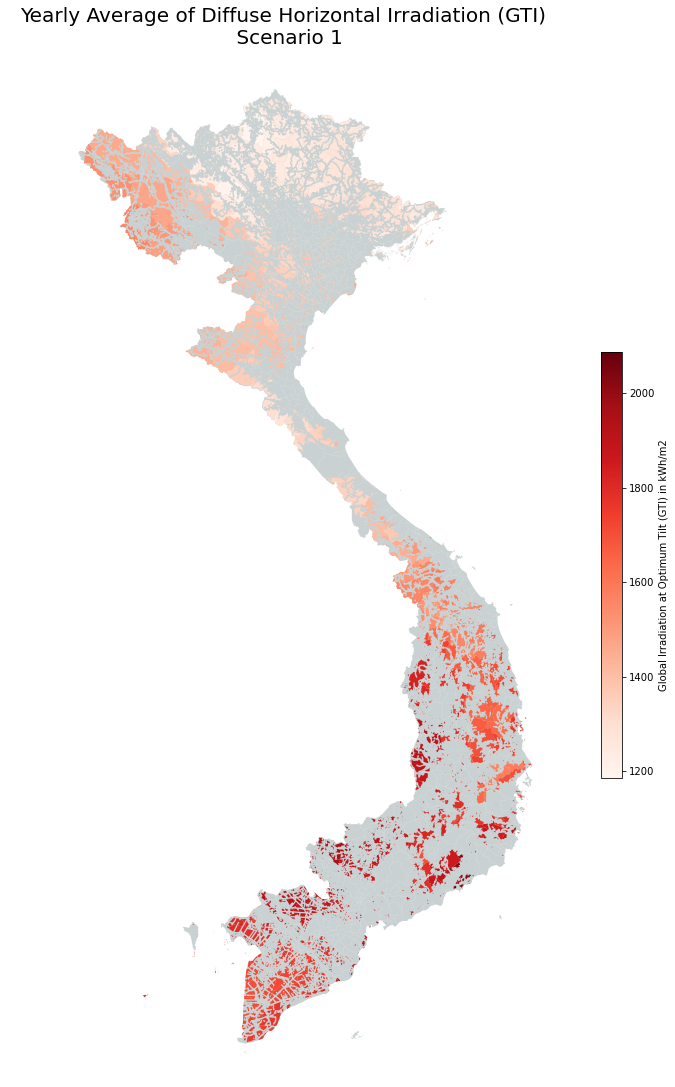

In [47]:
fig, ax = plt.subplots(figsize=(10, 20))

# Use VN_landuse boundary to define all sizes of the maps
ax.set_xlim(101, 110)
ax.set_ylim(8, 24)

# add basemap to the plot (grey)
new_map_gdf.plot(ax=ax, markersize=10, alpha=0.5, categorical=True, legend=True, color='#95A5A6')

# add basemap to the plot (grey)
#land_area_new_df.plot(ax=ax, markersize=10, alpha=0.5, categorical=True, legend=True, color='#95A5A6')
concat_sc1_dict['p7_sc1_gdf'].plot(column='gti_kWh/m2a', ax=ax, cmap='Reds', legend=True, legend_kwds={'shrink': 0.3, 'label': 'Global Irradiation at Optimum Tilt (GTI) in kWh/m2'})

# Set titles
ax.set_title('Yearly Average of Diffuse Horizontal Irradiation (GTI) \n Scenario 1', fontsize=20)
ax.set_axis_off()


plt.savefig(r'Vietnam/02_output_stage2/02_vn_scenario1_solar_gti.tiff', dpi=500)
plt.tight_layout()